In [63]:
# import
import os
import math
import joblib
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from IPython.display import display
from sklearn.model_selection import train_test_split

In [64]:
def load_dataset(data_csv, keep_cols) :
    # load
    df = pd.read_csv(data_csv, index_col=[0])

    # necessary columns
    df_reduced = df[keep_cols]

    # display
    print("dataset sample :")
    display(df_reduced.sample(2))

    print("dataset shape :")
    display(df_reduced.shape)
    return df_reduced


## RUN
accidents_csv = "../../db/shared/accidents_2R_75.csv"
keep_cols = ["lat", "long", "catv"]
accidents_df = load_dataset(accidents_csv, keep_cols)

dataset sample :


,lat,long,catv
1042,48.826913,2.377652,33
2255,48.871550,2.342675,31


dataset shape :


(4480, 3)

In [65]:
def cleanup_dataset(df) :
    # drop na
    df = df.dropna()

    # verify lat
    df = df.loc[df.lat <= 90.0]
    df = df.loc[df.lat >= -90.0]

    # verify lon
    df = df.loc[df.long <= 180.0]
    df = df.loc[df.long >= -180.0]

    # return
    return df

## RUN 
accidents_df = cleanup_dataset(accidents_df)

In [66]:
def create_radian_columns(df, lon_col, lat_col):
    # new col name
    rad_lon = "rad_" + lon_col
    rad_lat = "rad_" + lat_col


    df[rad_lon] = np.radians(df[lon_col].values)
    df[rad_lat] = np.radians(df[lat_col].values)
    return df, rad_lat, rad_lon

## RUN
lon_col = "long"
lat_col = "lat"
accidents_df, rad_lat, rad_lon = create_radian_columns(accidents_df, lon_col, lat_col)
accidents_df

,lat,long,catv,rad_long,rad_lat
0,48.883074,2.283707,33,0.039858,0.853171
1,48.847048,2.411057,33,0.042081,0.852542
2,48.872928,2.408648,33,0.042039,0.852994
3,48.856564,2.394438,33,0.041791,0.852708
4,48.891922,2.398340,32,0.041859,0.853325
...,...,...,...,...,...
4475,48.848598,2.372486,1,0.041408,0.852569
4476,48.864450,2.378830,33,0.041518,0.852846
4477,48.868801,2.367627,30,0.041323,0.852921
4478,48.856920,2.291953,43,0.040002,0.852714


In [67]:
def df_to_cluster(df, lat_col, lon_col) :
    return df[[lat_col, lon_col]]

accidents_for_model = df_to_cluster(accidents_df, rad_lat, rad_lon)
accidents_for_model

,rad_lat,rad_long
0,0.853171,0.039858
1,0.852542,0.042081
2,0.852994,0.042039
3,0.852708,0.041791
4,0.853325,0.041859
...,...,...
4475,0.852569,0.041408
4476,0.852846,0.041518
4477,0.852921,0.041323
4478,0.852714,0.040002


In [79]:
def cluster_model(df, hyperparam):

    # read hyperparameters
    eps_in_meters = hyperparam["eps_in_meters"]
    num_samples = hyperparam["num_samples"]
    metric_dist = hyperparam["metric_dist"]

    # eps in radians
    earth_perimeter = 40070000.0  # In meters
    eps_in_radians = eps_in_meters / earth_perimeter * (2 * math.pi)

    db_scan = DBSCAN(eps=eps_in_radians, min_samples=num_samples, metric=metric_dist)
    db_scan.fit(df[["rad_lat", "rad_long"]])

    # fit - clusters
    # df["cluster"] = db_scan.fit_predict(df)
    df["cluster"] = db_scan.labels_

    # metrics
    sil_score = round(metrics.silhouette_score(df, df['cluster']), 3)
    print(f"Score : {sil_score}")

    # return
    return df, sil_score

## RUN
hyperparam = {
    "eps_in_meters" : 50,
    "num_samples" : 5,
    "metric_dist" : "haversine"
}

accidents_df, sil_score = cluster_model(accidents_df, hyperparam)
len(set(accidents_df["cluster"]))
accidents_df.groupby(["cluster"]).count()

Score : -0.399


,lat,long,catv,rad_long,rad_lat
cluster,,,,,
-1,3578,3578,3578,3578,3578
0,8,8,8,8,8
1,8,8,8,8,8
2,7,7,7,7,7
3,5,5,5,5,5
...,...,...,...,...,...
139,5,5,5,5,5
140,6,6,6,6,6
141,5,5,5,5,5


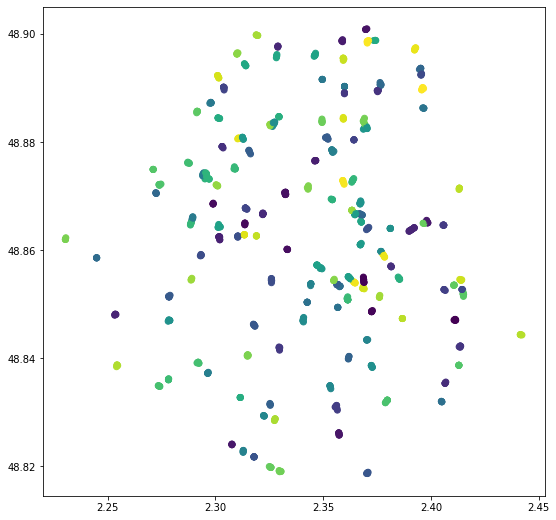

In [80]:
def plot_clusters(df) :
    """plot clusters
    """

    plt.figure(figsize=(9,9))
    plt.scatter(df["long"], df["lat"], c=df["cluster"])
    plt.show()

## RUN
mask = accidents_df["cluster"].isin([-1])
df_to_plot = accidents_df[~mask]
plot_clusters(df_to_plot)